# Prediction of density in basalts of the Serra Geral Group

- Joao Paulo G. R. Alves - 2024
- joao (dot) guilherme (dot) alves (at) usp (dot) br
- Institute of Energy and Environment - University of Sao Paulo
- This is the full research script, meaning some of the stuff her was not used in the final paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde, pearsonr
import scipy.stats as stats
import statsmodels.api as sm
import shap
import warnings
import os
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# Importing the well logs
cols = ['well', 'depth', 'dt', 'gr', 'res', 'sp', 'rhob']
rch = pd.read_excel('WellLogs_1_RCH_1_SC_dens__SG.xlsx', usecols = cols)
tp = pd.read_excel('WellLogs_1_TP_3_SC_dens__SG.xlsx', usecols = cols)
hv = pd.read_excel('WellLogs_1_HV_1_SC_dens__SG.xlsx', usecols = cols)

In [3]:
# Concating into one dataframe
data = pd.concat([rch, tp, hv])

In [4]:
# Droping unecessary data
data.drop(['depth', 'well'], axis=1, inplace=True)

In [5]:
# Reordering the columns
data = data[['dt', 'gr', 'res', 'sp', 'rhob']]

In [6]:
data.head()

,dt,gr,res,sp,rhob
0,121.577621,69.139801,0.037094,195.820801,2.327105
1,68.416580,77.543839,0.008055,189.445953,2.337859
2,76.521362,88.664368,0.001220,181.946106,2.334926
3,128.297180,99.759918,0.000663,174.508759,2.316593
4,123.315231,107.531784,0.000429,165.571442,2.286772


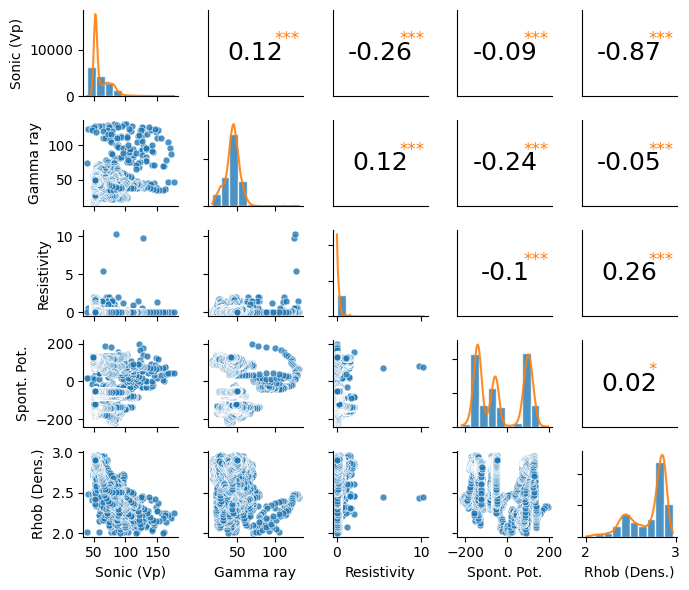

In [7]:
labels = ['Sonic (Vp)', 'Gamma ray', 'Resistivity', 'Spont. Pot.', 'Rhob (Dens.)']

# corrdot function to plot correlation coefficient
def corrdot(x, y, ax=None, **kwargs):
    corr_r = x.corr(y, 'pearson')
    corr_text = round(corr_r, 2)
    if ax is not None:
        ax.annotate(corr_text, xy=(0.5, 0.5), xycoords="axes fraction",
                    ha='center', va='center', fontsize=18)

# corrfunc function to plot significance stars
def corrfunc(x, y, ax=None, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05: p_stars = '*'
    if p <= 0.01: p_stars = '**'
    if p <= 0.001: p_stars = '***'
    if ax is not None:
        ax.annotate(p_stars, xy=(0.7, 0.6), xycoords="axes fraction",
                    color='tab:orange', fontsize=12)

# Num of variables
n = len(data.columns)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(7, 6))

# Plot each pair of variables
for i in range(n):
    for j in range(n):
        ax = axs[i, j]
        if i == j:  # Diagonal plot with histogram and KDE
             # Histogram without density normalization
            counts, bins, patches = axs[i, j].hist(data[data.columns[i]], bins=10, color='tab:blue', alpha = 0.8, edgecolor='white')
            if j == 0:
                axs[i, j].xaxis.set_ticklabels([])
            elif j == n-1:
                axs[i, j].yaxis.set_ticklabels([])
            else:
                axs[i, j].xaxis.set_ticklabels([])
                axs[i, j].yaxis.set_ticklabels([])
            # KDE
            kde = gaussian_kde(data[data.columns[i]])
            x_range = np.linspace(bins.min(), bins.max(), 100)

            # Scale KDE by the count to match histogram scale
            kde_values = kde(x_range) * sum(counts) * np.diff(bins)[0]

            axs[i, j].plot(x_range, kde_values, color='tab:orange', alpha = 0.9)
            
        elif j > i:
            corrdot(data[data.columns[i]], data[data.columns[j]], ax=ax)
            corrfunc(data[data.columns[i]], data[data.columns[j]], ax=ax)
            axs[i, j].set_facecolor('white')
            for spine in axs[i, j].spines.values():
                spine.set_visible(True)
                spine.set_color('black')
            axs[i, j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
        else:
            axs[i, j].scatter(data[data.columns[j]], data[data.columns[i]], color='tab:blue', 
                              edgecolor='white', alpha=0.8, linewidth=0.5, s = 25)

        # Add labels to the leftmost and bottom subplots
        if i == n - 1:
            axs[i, j].set_xlabel(labels[j])
                
        if j == 0:
            axs[i, j].set_ylabel(labels[i])
                
        axs[i, j].spines[['right', 'top']].set_visible(False)

        if i == n-1 and j != 0:
            axs[i, j].yaxis.set_ticklabels([])

        if j == 0 and i != n-1:
            axs[i, j].xaxis.set_ticklabels([])

        if i != n-1 and j != 0:
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
        
plt.tight_layout()
plt.show()

In [8]:
# Removing extreme outliers using Z-score
def z_score(x):
    return (x - np.mean(x)) / np.std(x)

data = data[(np.abs(z_score(data['dt'])) < 3) &
            (np.abs(z_score(data['gr'])) < 3) &
            (np.abs(z_score(data['res'])) < 3) &
            (np.abs(z_score(data['sp'])) < 3) &
            (np.abs(z_score(data['rhob'])) < 3)]

In [9]:
X = data.drop(columns = ['rhob'])
y = data['rhob']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
def preprocess_data(X, scale_transformer=None):
    # Copy the input DataFrame to avoid changes to the original data
    X_transformed = X.copy()

    # Apply Yeo-Johnson transformation
    if scale_transformer is None:
        # Initialize PowerTransformer with Yeo-Johnson
        scale_transformer = PowerTransformer(method='yeo-johnson', standardize=True) 
        # Fit and transform the data
        X_transformed = scale_transformer.fit_transform(X_transformed)
    else:
        # Transform data using the existing Box-Cox transformer
        X_transformed = scale_transformer.transform(X_transformed)

    # Convert the transformed array back to a DataFrame
    X_transformed_df = pd.DataFrame(X_transformed, columns=X.columns, index=X.index)

    return X_transformed_df, scale_transformer

In [12]:
X_train_transformed, scaler1 = preprocess_data(X_train)

In [13]:
X_test_transformed, _ = preprocess_data(X_test, scaler1)

In [14]:
# Adjusted parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5, 1, 5],   
    'reg_lambda': [0, 0.1, 0.5, 1, 5]  
}

In [15]:
# Instantiate XGBRegressor
xgboost_model = XGBRegressor(random_state=42)

In [16]:
# Cross-validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
# Randomized search for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(estimator=xgboost_model, 
                                    param_distributions=param_grid,  
                                    cv=cv_strategy,
                                    n_iter=10,
                                    verbose=2,
                                    random_state=42,  
                                    scoring='neg_root_mean_squared_error')

In [18]:
# Fit the model
random_search_xgb.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.4s
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.2s
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.2s
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.2s
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=100, reg_alpha=1, reg_lambda=0, subsample=0.6; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_d

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 4, ...], 'min_child_weight': [1, 5, ...], ...}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [19]:
print("Best parameters found: ", random_search_xgb.best_params_)

Best parameters found:  {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0}


In [20]:
# Extract the best model
best_xgb_model = random_search_xgb.best_estimator_

In [21]:
# Make predictions with the tuned model
xgb_predictions_tuned = best_xgb_model.predict(X_test_transformed)

In [22]:
def print_metrics(predictions, y_test, model_name):
    r2 = r2_score(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f"{model_name} - R2: {r2:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

In [23]:
print_metrics(xgb_predictions_tuned, y_test, "Tuned Model")

Tuned Model - R2: 0.91, RMSE: 0.06, MAE: 0.04


In [24]:
def plot_learning_curves_on_ax(ax, estimator, title, X, y, cv, n_jobs=-1):
    """
    Generate a plot of the test and training learning curves on a given ax.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the mean scores
    ax.plot(train_sizes, train_scores_mean, 'o-', color="tab:blue", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="tab:orange", label="Cross-validation score")

    # Plot the standard deviation
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="tab:blue")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="tab:orange")
                     
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Training Examples", fontsize=10)
    ax.set_ylabel("Root Mean Squared Error (RMSE)", fontsize=10)
    ax.legend(loc="best", fontsize=10)

In [25]:
explainer = shap.TreeExplainer(best_xgb_model)

In [26]:
shap_values = explainer.shap_values(X_test_transformed)

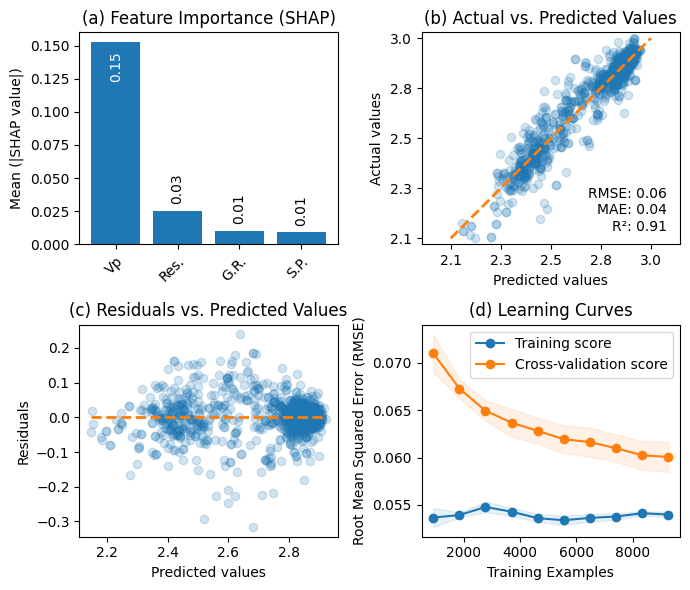

In [27]:
# Plotting metrics of the model
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 6))
axs = axs.flatten()

# --- Plot 1: Mean SHAP Values (Top-Left) ---
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]
sorted_features = X_test_transformed.columns[sorted_indices]
sorted_mean_abs_shap_values = mean_abs_shap_values[sorted_indices]

bars = axs[0].bar(sorted_features, sorted_mean_abs_shap_values, color='tab:blue')
axs[0].set_xticklabels(['Vp', 'Res.', 'G.R.', 'S.P.'], rotation=45, ha='right', rotation_mode="anchor")
axs[0].set_ylabel("Mean (|SHAP value|)")
axs[0].set_title("(a) Feature Importance (SHAP)", fontsize=12)

for idx, bar in enumerate(bars):
    height = bar.get_height()
    if idx == 0:
        axs[0].text(bar.get_x() + bar.get_width()/2., 0.88*height, 
                    '%.2f' % float(height), ha='center', va='center', 
                    color='white', rotation=90, fontweight='normal')
    else:
        axs[0].text(bar.get_x() + bar.get_width()/2., height+0.005,  
                    '%.2f' % float(height), ha='center', va='bottom', 
                    color='black', rotation=90, fontweight='normal')

# --- Plot 2: Actual vs. Predicted (Top-Right) ---
PredictionErrorDisplay.from_estimator(
    best_xgb_model, X_test_transformed, y_test, kind="actual_vs_predicted", ax=axs[1],
    scatter_kwargs={"alpha": 0.2, "color": 'tab:blue'}, line_kwargs={"alpha": 1, "color": 'tab:orange', "linewidth": 2}
)
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].set_title("(b) Actual vs. Predicted Values", fontsize=12)

# Calculate metrics
rmse_val = root_mean_squared_error(y_test, best_xgb_model.predict(X_test_transformed))
mae_val = mean_absolute_error(y_test, best_xgb_model.predict(X_test_transformed))
r2_val = r2_score(y_test, best_xgb_model.predict(X_test_transformed))

axs[1].text(0.95, 0.05, f'RMSE: {rmse_val:.2f}\nMAE: {mae_val:.2f}\nR²: {r2_val:.2f}', 
            transform=axs[1].transAxes, verticalalignment='bottom', horizontalalignment='right')

# --- Plot 3: Residuals vs. Predicted (Bottom-Left) ---
PredictionErrorDisplay.from_estimator(
    best_xgb_model, X_test_transformed, y_test, kind="residual_vs_predicted", ax=axs[2],
    scatter_kwargs={"alpha": 0.2, "color": 'tab:blue'}, line_kwargs={"alpha": 1, "color": 'tab:orange', "linewidth": 2}
)
axs[2].set_ylabel("Residuals")
axs[2].set_title("(c) Residuals vs. Predicted Values", fontsize=12)

# Learning curves
plot_learning_curves_on_ax(
    ax=axs[3],
    estimator=best_xgb_model,  
    title="(d) Learning Curves", 
    X=X_train_transformed, 
    y=y_train, 
    cv=cv_strategy
)

plt.tight_layout()
plt.show()

In [28]:
# Perform LOWESS smoothing
def lowess_smoothing(x, y, frac=0.1):
    return sm.nonparametric.lowess(y, x, frac=frac)

# Bootstrap function for LOWESS confidence intervals
def bootstrap_lowess_ci(x, y, frac=0.1, n_boot=100, ci=95):
    # Store bootstrapped lowess curves
    boot_lowess_curves = np.zeros((n_boot, len(x)))
    
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.choice(range(len(x)), size=len(x), replace=True)
        x_resampled, y_resampled = x[indices], y[indices]
        
        # LOWESS smoothing on resampled data
        lowess_resampled = lowess_smoothing(x_resampled, y_resampled, frac=frac)
        
        # Sort by x to keep the curve order
        sorted_indices = np.argsort(lowess_resampled[:, 0])
        boot_lowess_curves[i] = lowess_resampled[sorted_indices, 1]
    
    # Calculate percentiles for confidence intervals
    lower_bound = np.percentile(boot_lowess_curves, (100 - ci) / 2., axis=0)
    upper_bound = np.percentile(boot_lowess_curves, 100 - (100 - ci) / 2., axis=0)
    
    return lower_bound, upper_bound

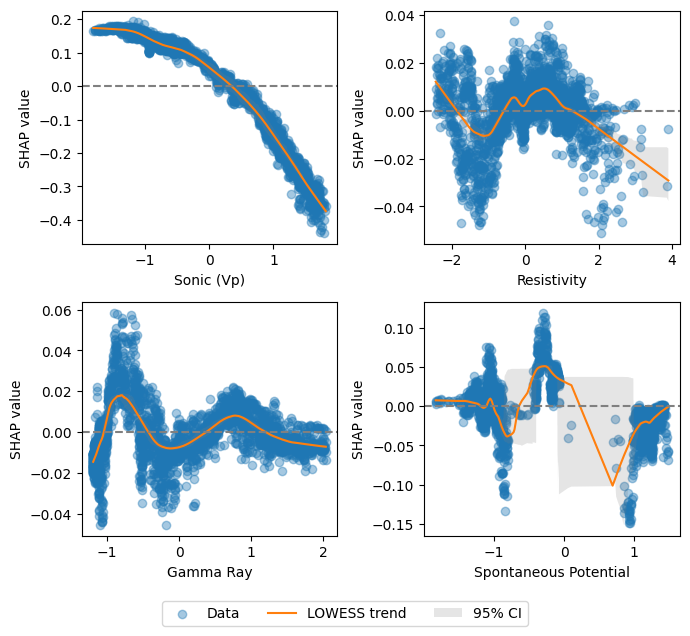

In [29]:
# Original list of feature names from `X_full_transformed`
original_features = X_test_transformed.columns.to_list()

# renamed feature names for display
renamed_features = ['Sonic (Vp)', 'Resistivity', 'Gamma Ray', 'Spontaneous Potential']

# fill_kwargs
fbk = {'lw':0.0, 'edgecolor':None}

# Setup the figure
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
axes = axes.flatten()  # Flatten the 2x2 grid into a 1D array for easier indexing

# Loop through each original feature name and its corresponding new name
for idx, (original_feature_name, renamed_feature_name) in enumerate(zip(original_features, renamed_features)):
    # Extract SHAP values for the specific feature
    if isinstance(shap_values, list):
        shap_values_for_feature = shap_values[0][:, X_test_transformed.columns.get_loc(original_feature_name)]
    else:
        shap_values_for_feature = shap_values[:, X_test_transformed.columns.get_loc(original_feature_name)]

    # Original LOWESS smoothing
    lowess_original = lowess_smoothing(X_test_transformed[original_feature_name], shap_values_for_feature, frac=0.2)

    # Calculate confidence intervals via bootstrapping
    lower_bound, upper_bound = bootstrap_lowess_ci(X_test_transformed[original_feature_name].values, shap_values_for_feature, frac=0.2, n_boot=100, ci=95)

    # Plotting for the current feature
    ax = axes[idx]
    scatter = ax.scatter(X_test_transformed[original_feature_name], shap_values_for_feature, alpha=0.4, label='Data', color='tab:blue')
    line = ax.plot(lowess_original[:, 0], lowess_original[:, 1], color="tab:orange", label='LOWESS trend', alpha=1)
    ci_fill = ax.fill_between(lowess_original[:, 0], lower_bound, upper_bound, color='tab:grey', alpha=0.2, label='95% CI', **fbk)
    hline = ax.axhline(y=0, color='grey', linestyle='--')
    ax.set_xlabel(renamed_feature_name)
    ax.set_ylabel('SHAP value')
    #ax.legend(fontsize = 9)


# Create legend
fig.legend([scatter, line[0], ci_fill, hline], ['Data', 'LOWESS trend', '95% CI'], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.tight_layout()
plt.show()

In [30]:
"""
# Predicting new data of the other wells
directory = '/home/joao/Documents_Ubuntu/Projeto_DLISIO/Dados_Filtrados_SG_XLSX'
directory_dens = '/home/joao/Documents_Ubuntu/Projeto_DLISIO/Dados_Predicted_Dens'
"""

"\n# Predicting new data of the other wells\ndirectory = '/home/joao/Documents_Ubuntu/Projeto_DLISIO/Dados_Filtrados_SG_XLSX'\ndirectory_dens = '/home/joao/Documents_Ubuntu/Projeto_DLISIO/Dados_Predicted_Dens'\n"

In [31]:
"""
for filename in os.listdir(directory):
    if filename.endswith(".xlsx"):
        file_path = os.path.join(directory, filename)
        data = pd.read_excel(file_path)
        X_original = data.copy()

        X_new = data.drop(columns=['well', 'depth'])  # Drop the 'well' column if it's not a feature
        X_new = X_new[['dt', 'gr', 'res', 'sp']]

        X_new_transformed, _ = preprocess_data(X_new, scaler1)
        predictions_new = best_xgb_model.predict(X_new_transformed)
        X_original['Density'] = predictions_new
        
        # Create a new filename by removing the extension and adding '_dens.xlsx'
        new_filename = filename[:-5] + '_dens.xlsx'  # Removes '.xlsx' and adds '_dens.xlsx'
        new_file_path = os.path.join(directory_dens, new_filename)

        # Save the updated DataFrame
        X_original.to_excel(new_file_path, index=False)
"""

'\nfor filename in os.listdir(directory):\n    if filename.endswith(".xlsx"):\n        file_path = os.path.join(directory, filename)\n        data = pd.read_excel(file_path)\n        X_original = data.copy()\n\n        X_new = data.drop(columns=[\'well\', \'depth\'])  # Drop the \'well\' column if it\'s not a feature\n        X_new = X_new[[\'dt\', \'gr\', \'res\', \'sp\']]\n\n        X_new_transformed, _ = preprocess_data(X_new, scaler1)\n        predictions_new = best_xgb_model.predict(X_new_transformed)\n        X_original[\'Density\'] = predictions_new\n\n        # Create a new filename by removing the extension and adding \'_dens.xlsx\'\n        new_filename = filename[:-5] + \'_dens.xlsx\'  # Removes \'.xlsx\' and adds \'_dens.xlsx\'\n        new_file_path = os.path.join(directory_dens, new_filename)\n\n        # Save the updated DataFrame\n        X_original.to_excel(new_file_path, index=False)\n'